In [16]:
## User Identification Report

<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
<center>


<h1>Plan</h1>

<ul>
<li>[+] - цели и задачи проекта, описание исходных и обработанных данных и признаков.</li>
<li>[+] - первичный анализ признаков</li>
<li>[+] - первичный визуальный анализ признаков</li>
<li>[+] - если пришли к каким-то "инсайтам", обнаружили закономерности – изложите</li>
<li>[+] - описание предобработки данных</li>
<li>[+] - если создаются признаки, то описание этого процесса</li>
<li>[+] - кросс-валидация, построение кривых валидации и обучения</li>
<li>[+] - оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться</li>
<li>[+] - выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.</li>

### Цель проекта:

Главная цель проекта - по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком - идентифицировать этого человека. 
### Задачи: 
1. Подготовить файлы для использования их в качестве тренировочных данных для обработки компьютером.
2. Найти и выделить интерпретируемые признаки для пользователей.
3. Визуально проанализировать признаки.
4. Представить данные в подходящем для алгоритмов машинного обучения виде - матрицы объекты - признаки.
5. Отобрать лучшие признаки, проетстировать модель в бою.

In [17]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm_notebook, tqdm
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
import itertools
# Путь к данным
PATH_TO_DATA = r'D:\_WORK\ml-big4\ml-big4\UserIdentification\data'

## I. Первичный анализ данных

В результате обработки и подготовки файлов удалось выделить из данных следующие группы признаков:

    I. Сайты в пользовательской сессии 
        * Какие сайты пользователь посещает
        * Как часто он посещает популярные сайты
        * Пользуется ли он разнообразными сайтами или одними и теми же
    II. Время между переходами пользователем с одного сайта на другой 
        * Среднее время проводимое на сайтах
        * Средняя длина сессии
    III. Предпочитаемое пользователем время для интернет-сёрфинга
        * День недели
        * Час начала сесии
        * Год (мы имеем данные разных лет)
    
Основная гипотеза исследования - эти признаки мы можем использовать в практических задачах. Например, зная основные характеристики поведения отличить пользователя от взломщика и вовремя заблокировать доступ к персональной информации.

In [18]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    from re import search
    with open(site_freq_path, 'rb') as inf:
        dct = pickle.load(inf)
        sessions = []
        
    for filename in tqdm(glob(path_to_csv_files + '/*.csv')):
        user_id = int(search(r'(\d{4})', filename).group())
        df = pd.read_csv(filename, parse_dates=['timestamp'])
        sites = df['site']
        times = df['timestamp'].diff().dt.seconds[1:].reset_index(drop=True)
        
        for j in range(0, df.shape[0], window_size):
            session = [0] * (session_length*2 - 1)
            
            unique = set()
            #print(times)
            
            for i in range(min(session_length, len(sites) - j)):
                session[i] = dct[sites[i+j]][0]
                unique.add(dct[sites[i+j]][0])

            
            for i in range(session_length, min(2*session_length-1, len(times) - j + session_length)):
                    session[i] = times[i+j-session_length]

                    
            session.append(sum(session[-9:]))
            session.append(len(unique))
            session.append(df.loc[j,'timestamp'].hour)
            session.append(df.loc[j,'timestamp'].dayofweek)
            session.append(user_id)
            sessions.append(session)
        
    return pd.DataFrame(np.array(sessions).astype(int), columns=feature_names)
        
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
        
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

train_data_10users.head()

100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s]


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1314,2306,4318,4172,4318,4318,4172,4318,2455,4318,...,20,1,0,1,0,33,5,8,4,31
1,4869,3050,2897,941,4318,206,252,1663,2354,3722,...,0,1,3,3,8,284,10,8,4,31
2,3722,4172,3722,3722,4104,3069,4869,2906,993,3722,...,0,0,1,0,0,258,7,8,4,31
3,370,1837,370,3722,3722,3722,3722,3589,3056,348,...,25,1,0,0,0,30,6,8,4,31
4,2993,3722,4104,1659,2336,2915,1759,629,1063,629,...,1,0,1,1,0,6,9,8,4,31


Это пример признакового описания сессий пользователя.

In [19]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    
    from re import search
    with open(site_freq_path, 'rb') as inf:
        dct = pickle.load(inf)
        sessions = []
        
    top30_sites = [x[0] for x in sorted(dct.items(), key=lambda t: t[1][1], reverse=True)[:30]]
    for filename in tqdm(glob(path_to_csv_files + '/*.csv')):
        user_id = int(search(r'(\d{4})', filename).group())
        df = pd.read_csv(filename, parse_dates=['timestamp'])

        sites = df['site']
        times = df['timestamp'].diff().dt.seconds[1:].reset_index(drop=True)
        
        for j in range(0, df.shape[0], window_size):
            session = [0]*30
            times_local = [0] * (session_length-1)
            #unique = set()
            #print(times)
            
            for i in range(min(session_length-1, len(times) - j)):
                times_local[i] = times[i+j]
            
            for i in range(min(session_length, len(sites) - j)):
                if sites[i+j] in top30_sites:
                    try:
                        session[top30_sites.index(sites[i+j])] += times_local[i]
                    except IndexError:
                        session[top30_sites.index(sites[i+j])] += 1
                        
            #session.append(int(sum(session) != 0))
            session.append(user_id)
            sessions.append(session)

    return pd.DataFrame(np.array(sessions).astype(int), columns=(top30_sites+['user_id']))

new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'), session_length=10)

new_features_10users.head()

100%|██████████████████████████████████████████| 10/10 [00:02<00:00,  4.11it/s]


,s.youtube.com,www.google.fr,www.google.com,mail.google.com,www.facebook.com,apis.google.com,r3---sn-gxo5uxg-jqbe.googlevideo.com,r1---sn-gxo5uxg-jqbe.googlevideo.com,plus.google.com,accounts.google.com,...,platform.twitter.com,clients6.google.com,safebrowsing-cache.google.com,translate.google.fr,api.twitter.com,accounts.google.fr,talkgadget.google.com,mts0.google.com,clients2.google.com,user_id
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31
2,0,0,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31


Это признаки времени проведенного пользователем в рамках одной сессии на популярных сайтах.

## II. Первичный визуальный анализ данных

### - Содержание сессии

Посмотрим визуально, как посещенные сайты отличаются у разных пользователей.

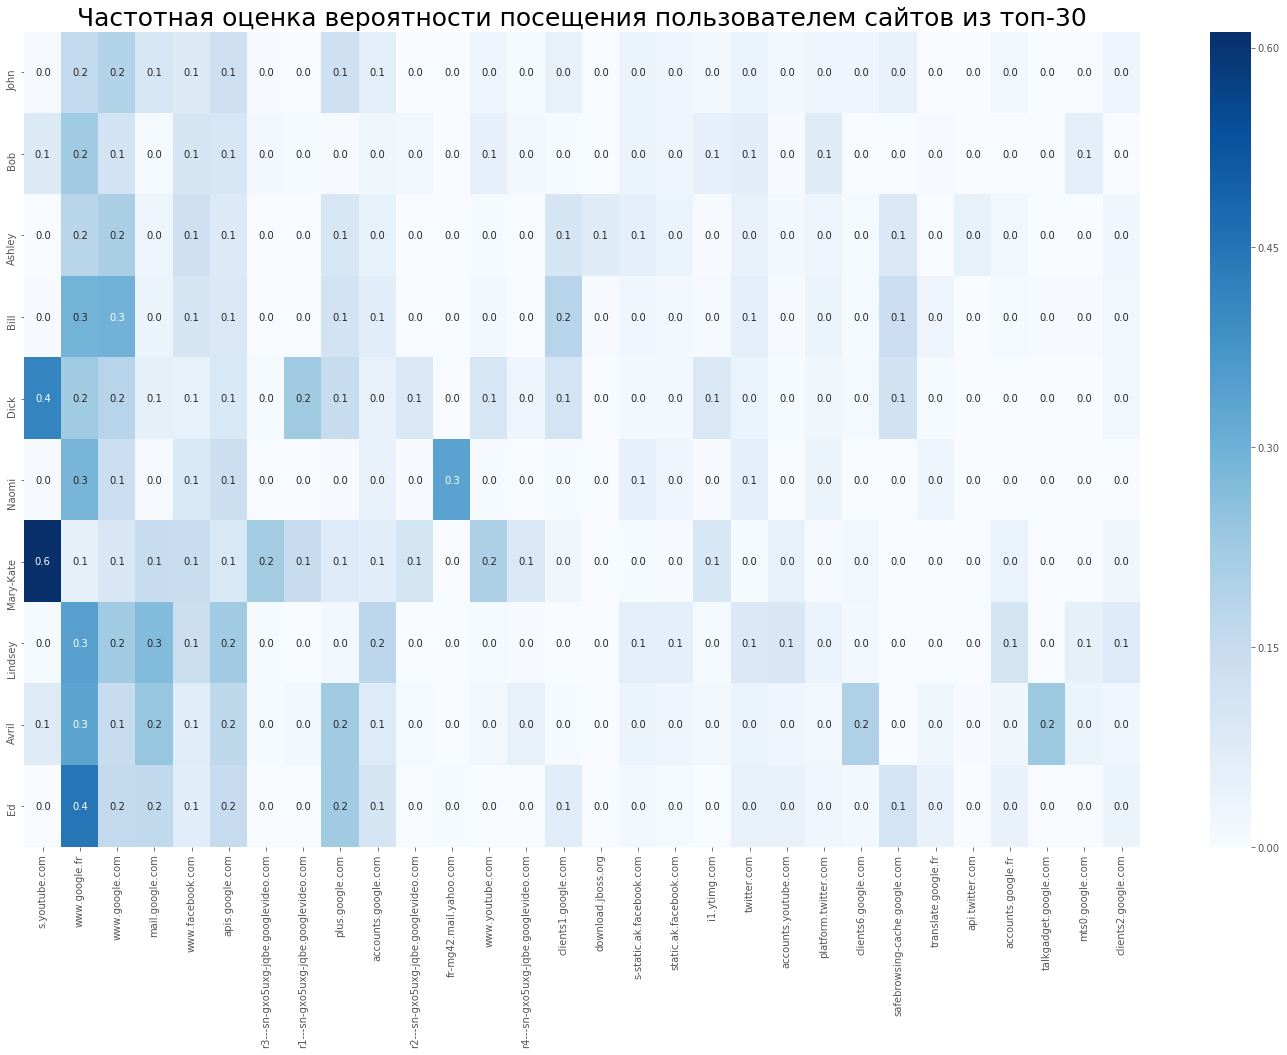

In [20]:
heatmap_df = new_features_10users.groupby('user_id').agg('mean')

id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)


heatmap_df_probs = pd.concat([(new_features_10users.iloc[:,:-1] != 0).astype(int),
                              new_features_10users[['user_id']]], axis=1).groupby('user_id').agg('mean')
plt.figure(figsize=(25,15))
ax = sns.heatmap(heatmap_df_probs, annot=True, fmt='.1f', cmap='Blues',
            yticklabels=heatmap_df.reset_index()['user_id'].map(id_name_dict).values)
ax.set_title(u"Частотная оценка вероятности посещения пользователем сайтов из топ-30", fontsize=25)
ax.set_ylabel('');

На примере 10 пользователей мы можем видеть, что они выделяются тем, что стабильно в каждую сессию  посещают одни и теже сайты.
Например Mary-Kate в 60% процентах сессий посещает сайт youtube.com, а Наоми в отличие от остальных в 30% процентах сессий заходит на сайт yahoo.com.
(сумма по строкам может быть больше 1, так как сессия состоит из 10 сайтов, поэтому возможна даже ситуация вероятности 1 для нескольких сайтов)

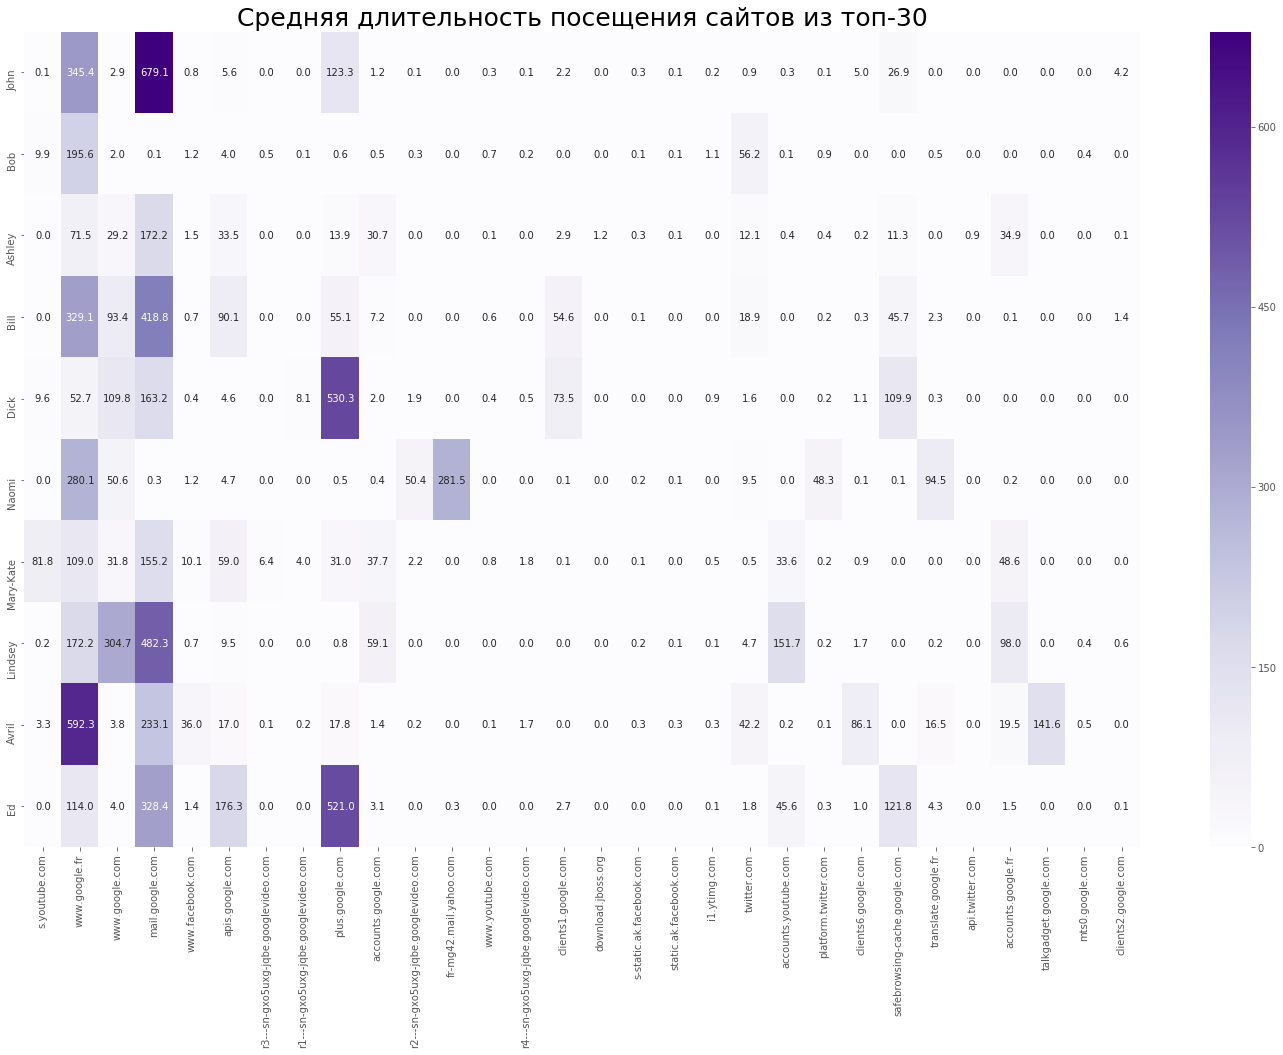

In [21]:
plt.figure(figsize=(25,15))
ax = sns.heatmap(heatmap_df.groupby('user_id').agg('mean'), annot=True, fmt='.1f', cmap='Purples',
            yticklabels=heatmap_df.reset_index()['user_id'].map(id_name_dict).values)
ax.set_title(u"Средняя длительность посещения сайтов из топ-30", fontsize=25)
ax.set_ylabel('');

Также мы можем увидеть, что анализ времени, которое пользователь проводит на любимых сайтах, помогает выделить тех из них, которые препочитают сидеть пододолгу.
Аврил, к примеру, любит много времени потратить в гугле, а Джон проводит время читая свою почту.

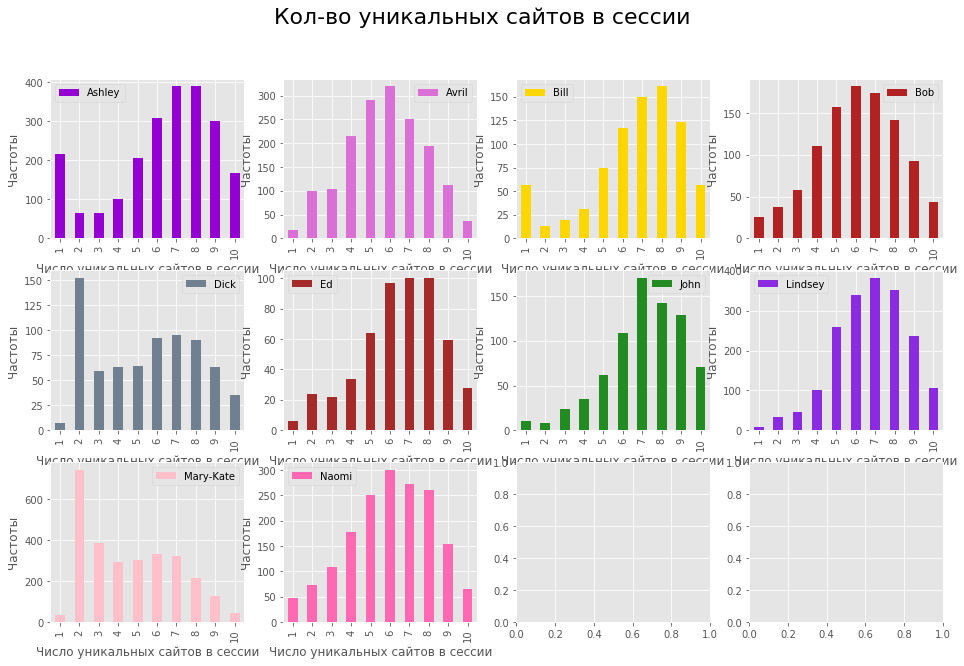

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    row, col = idx%4, idx//4
    sub_df['#unique_sites'].value_counts().sort_index().plot(kind='bar', ax=axes[col][row], color=color_dic[user], label = user)
    axes[col][row].legend()
    axes[col][row].set_xlabel(u'Число уникальных сайтов в сессии')
    axes[col][row].set_ylabel(u'Частоты')
fig.suptitle('Кол-во уникальных сайтов в сессии', size=22);

Кол-во уникальных сайтов в сессии визуально у всех пользователей очень похоже, от 6 до 8 уникальных сайтов в сессии, кроме разве что Мэри-Кейт и Дика, которые, как мы выше увидели,стабильно заходят на свои любимые сайты в каждой сессии.

### Время посещений

Вторая группа признаков связанные с временем посещения пользователем интернета.

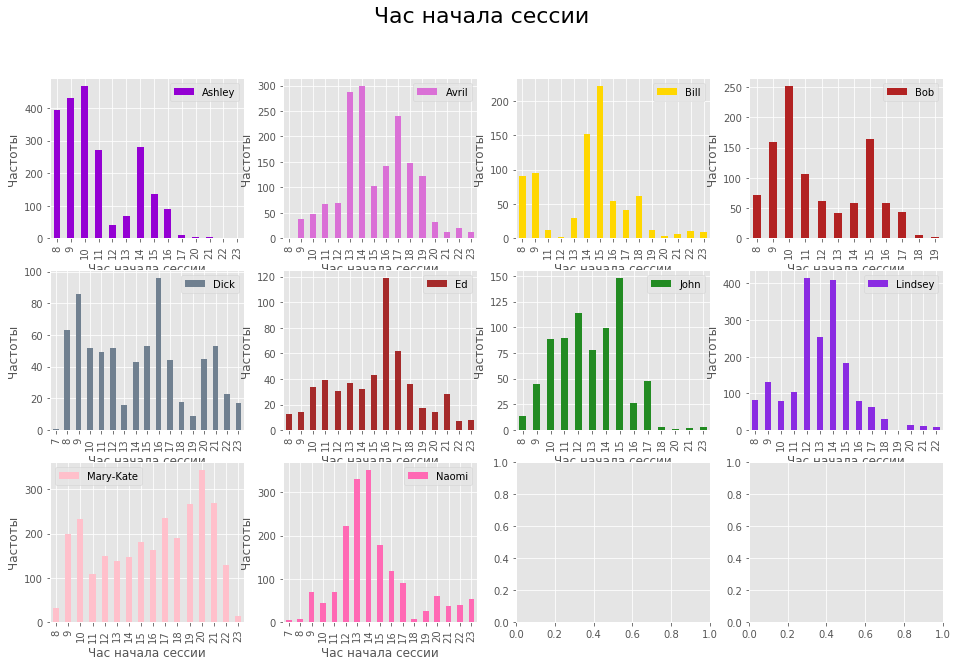

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    row, col = idx%4, idx//4
    sub_df['start_hour'].value_counts().sort_index().plot(kind='bar', ax=axes[col][row], color=color_dic[user], label = user)
    axes[col][row].legend()
    axes[col][row].set_xlabel(u'Час начала сессии')
    axes[col][row].set_ylabel(u'Частоты')
fig.suptitle(u'Час начала сессии', size=22);

Визуально этот признак позволяет хорошо различить таких пользователей как Эшли, которая посещает интернет преймущественно в рабочие часы, тем самым как Эд, Дик, Наоми, Мэри-Кейт всегда онлайн.

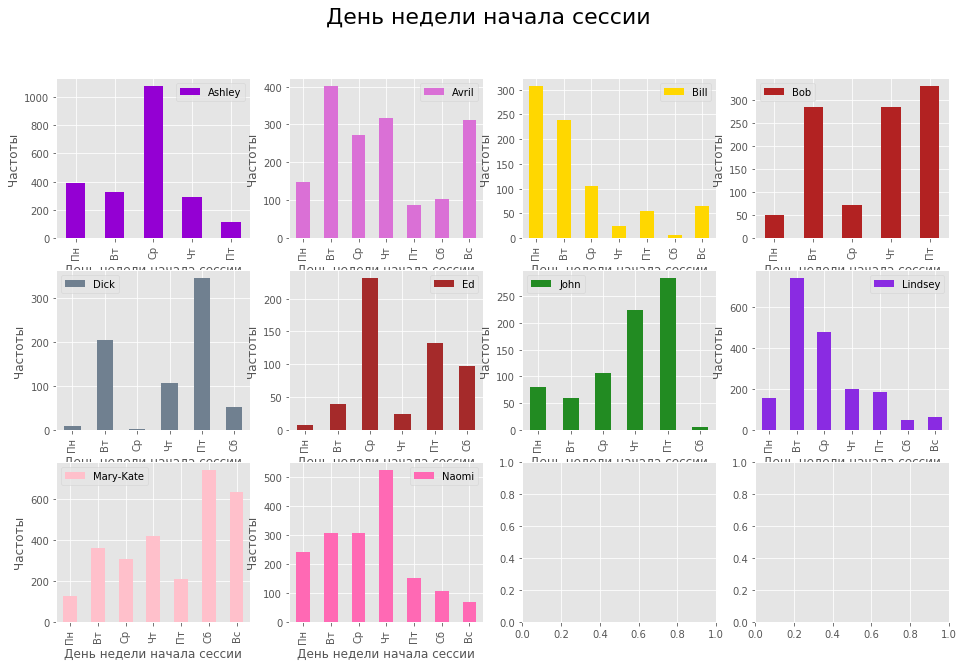

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    row, col = idx%4, idx//4
    sub_df['day_of_week'].value_counts().sort_index().plot(kind='bar', ax=axes[col][row], color=color_dic[user], label = user)
    axes[col][row].legend()
    axes[col][row].set_xlabel(u'День недели начала сессии')
    axes[col][row].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[col][row].set_ylabel(u'Частоты')
fig.suptitle(u'День недели начала сессии', size=22);

С помощью этого признака мы сможем отличить всегда Боба и Эшли от всех остальных, потому что они не выходят онлайн в выходные дни.

## III. Предобработка данных

Т.к. данные изначально были в формате, которые не подходят для прямого использования ни моделью машинного обучения, не позволяют сделать никаких выводов мы предварительно их обработали.

1. Посещенные сайты:
    Как упоминалось выше последовательность посещенных пользователем сайтов мы преобразовали в сессии. Когда мы определимся с моделью, мы подберем параметры длины сессии и ширины окна, так, чтобы качество классификации было наилучшим.
    В дальнейшем: 
    - Сайты кодировались цифрой для экономии памяти и в угоду быстродействию. 
    - Для модели сайты подавались с помощью метода "Мешок слов".
    - Кол-во уникальных сайтов - число уникальных сайтов в сессии
    
    Время, которое пользователь провел на сайте расчитывалось как разница во времени между посещениями.
    
2. Временные признаки:
    Собственно из известной полной даты зарегистрированного посещения выделялись отдельно:
    - Час посещения
    - День недели
    
P.S. функции, которые я использовал для подсчета введены в начале.
    

## IV. Выбор модели.

- Модель подбирали используя данные 10 пользователей. 
- Мы используем технику отложеной выборки в 30% и кросс-валидацию на тренировочной.
- В качестве метрики качества будем использовать долю верных классификаций(accuracy) в задаче мультиклассовой классификации, так как явного дисбаланса классов мы не ожидаем, приоритетов в идентификации конкретных пользователей не имеем.

In [25]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)  
    
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'rb') as inf:
    new_features_10users = pickle.load(inf)
          
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'rb') as selected_features_10users:
    selected_features_10users = pickle.load(selected_features_10users).drop('user_id', axis=1)

scaler = StandardScaler()

X = hstack([X_sparse_10users,
            scaler.fit_transform(new_features_10users.values), 
            scaler.fit_transform(selected_features_10users.values)], format='csr')

X_train, X_valid, y_train, y_valid = train_test_split(X, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

cv_holdouts = dict()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\_WORK\\ml-big4\\ml-big4\\UserIdentification\\data\\new_features_10users.pkl'

- Пробуем линейные, метрические, "деревянные" модели с автоматической настройкой основных гиперпараметров

In [15]:
%%time

models = {'Support Vector Machine': {'model':LinearSVC(C=1, random_state=17),
                 'param': 'C',
                 'range': np.linspace(1e-3, 1, 30)},
          'k Nearest Neighbors': {'model': KNeighborsClassifier(n_jobs=-1, n_neighbors=100),
                 'param': 'n_neighbors',
                 'range': [1, 3, 5, 10, 50, 100]}, 
         'Random Forest': {'model': RandomForestClassifier(random_state=17, n_jobs=-1),
                   'param': 'n_estimators',
                    'range': [5, 10, 50, 100]},
         'Logistic Regression': {'model': LogisticRegression(random_state=17, n_jobs=-1),
                  'param': 'C',
                  'range': np.logspace(-4, 2, 10)}}

cv_holdouts = dict()

for algorithm in tqdm(models):
    model = models[algorithm]['model']
    param = models[algorithm]['param']
    rng = models[algorithm]['range']
    
    
    grid = {param : rng}
    gs = GridSearchCV(estimator=model, param_grid=grid, cv=skf, scoring='accuracy', n_jobs=-1 )
    gs.fit(X_train, y_train)
    cv_score = gs.best_score_
    acc_score = accuracy_score(y_valid, gs.predict(X_valid))
    cv_holdouts[algorithm] = (cv_score, acc_score)

scores = pd.DataFrame(list(cv_holdouts.values()),index=[name for name in cv_holdouts],
             columns=['CV score','Hold out Score'])
best_model = scores['Hold out Score'].argmax()
scores.plot(kind='bar', figsize=(10,6))
plt.title("Scores for machine learning models")
plt.ylim(0,1)
plt.legend(loc=4);
print('Best score - {}, model - {}'.format(np.round(scores.loc[best_model,'Hold out Score'].max(),3), best_model))

  0%|                                                    | 0/4 [00:00<?, ?it/s]


NameError: name 'skf' is not defined

Как мы видим на наборе данных из 10 пользователей победила линейная модель логистической регрессии,также схожий результат показал метод опорных векторов. Для дальнейшей работы возьмем логистическую регрессию.

Best parameter - {'C': 1.0}


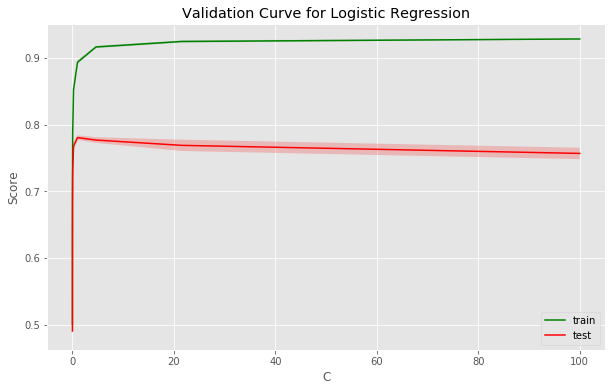

In [15]:
gs = GridSearchCV(estimator=models[best_model]['model'],
                  param_grid={models[best_model]['param'] : models[best_model]['range']},
                  cv=skf, scoring='accuracy', n_jobs=-1 )
gs.fit(X_train, y_train)
plt.figure(figsize=(10,6))
plot_validation_curves(models[best_model]['range'], gs.cv_results_)
plt.title('Validation Curve for {}'.format(best_model))
plt.xlabel('C')
plt.ylabel('Score');
print('Best parameter - {}'.format(gs.best_params_))

Как можно увидеть мы нашли локальный максумум и дальнейшее увеличение коэфициента регуляризации ухудшает обощающую способность алгоритма. Также отмечу относительно малое среднеквадратичное  отклонение на тестовых данных.

In [16]:
%%time

def model_assessment(estimator,
                     path_to_X_pickle,
                     path_to_new_features_pickle,
                     path_to_selected_features_pickle,
                     path_to_y_pickle,
                     cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as inf:
        X_sparce = pickle.load(inf)
    with open(path_to_new_features_pickle, 'rb') as inf:
        new_features = pickle.load(inf)    
    with open(path_to_selected_features_pickle, 'rb') as inf:
        selected_features = pickle.load(inf).drop('user_id', axis=1)
        
    X = hstack([X_sparce,
            scaler.fit_transform(new_features.values), 
            scaler.fit_transform(selected_features.values)], format='csr')
        
    with open(path_to_y_pickle, 'rb') as inf:
        y = pickle.load(inf) 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=random_state, stratify=y)
    cv_score = cross_val_score(estimator=estimator, cv=cv, X=X_train, y=y_train, n_jobs=-1, scoring='accuracy', verbose=0)
    estimator.fit(X_train, y_train)
    test_score = accuracy_score(y_test, estimator.predict(X_test))
    return round(cv_score.mean(),3), round(test_score,3)


estimator = gs
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_nf = os.path.join(PATH_TO_DATA, 'new_features_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_sf = os.path.join(PATH_TO_DATA, 'selected_features_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        
        print('cv score: {}, test_score: {}'.format(*model_assessment(estimator, 
                 path_to_X_pkl, path_to_nf, path_to_sf, path_to_y_pkl, skf, random_state=17, test_size=0.3)), 'window: {}, session {}'.format(window_size, session_length))

cv score: 0.857, test_score: 0.875 window: 10, session 15
cv score: 0.78, test_score: 0.794 window: 10, session 10
cv score: 0.883, test_score: 0.894 window: 7, session 15
cv score: 0.842, test_score: 0.851 window: 7, session 10
cv score: 0.802, test_score: 0.806 window: 7, session 7
cv score: 0.905, test_score: 0.911 window: 5, session 15
cv score: 0.859, test_score: 0.873 window: 5, session 10
cv score: 0.823, test_score: 0.839 window: 5, session 7
cv score: 0.787, test_score: 0.801 window: 5, session 5
CPU times: user 2min 40s, sys: 1.36 s, total: 2min 41s
Wall time: 52min 41s


При подборе таких параметров для длины сессии и ширины "окна" лучшие результаты даёт длина сессии 15 с шириной окна 5, но для 150 пользователей лучших результатов удалось достигнуть при обоих параметрах равных 10.

## V. Тестирование.

Загрузим данные по 150 пользователям и протестируем модель.

In [17]:
%%time
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_150users_s10_w10.pkl'), 'rb') as inf:
    X_sparse_150users = pickle.load(inf)
with open(os.path.join(PATH_TO_DATA, 
                       'y_150users_s10_w10.pkl'), 'rb') as inf:
    y_150users = pickle.load(inf)  
    
with open(os.path.join(PATH_TO_DATA, 'new_features_150users_s10_w10.pkl'), 'rb') as inf:
    new_features_150users = pickle.load(inf)
          
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users_s10_w10.pkl'), 'rb') as inf:
    selected_features_150users = pickle.load(inf).drop('user_id', axis=1)

scaler = StandardScaler()

X = hstack([X_sparse_150users,
            scaler.fit_transform(new_features_150users.values), 
            scaler.fit_transform(selected_features_150users.values)], format='csr')

X_train, X_valid, y_train, y_valid = train_test_split(X, y_150users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_150users)


logit_cv_150users = LogisticRegressionCV(random_state=17, n_jobs=-1, multi_class='ovr', Cs=[1])
logit_cv_150users.fit(X_train, y_train)

CPU times: user 8min 13s, sys: 1.1 s, total: 8min 14s
Wall time: 19min 19s


In [18]:
class_distr = (y_train.shape[0] - np.bincount(y_train.astype('int')))/y_train.shape[0]

for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, np.round(logit_cv_150users.scores_[user_id].mean(), 3)))

User 1, CV score: 0.994
User 2, CV score: 0.991
User 3, CV score: 0.997
User 4, CV score: 0.995
User 5, CV score: 0.996
User 6, CV score: 0.997
User 7, CV score: 0.996
User 8, CV score: 0.993
User 9, CV score: 0.994
User 10, CV score: 0.997
User 11, CV score: 0.984
User 12, CV score: 0.997
User 13, CV score: 0.996
User 14, CV score: 0.995
User 15, CV score: 0.994
User 16, CV score: 0.988
User 17, CV score: 0.997
User 18, CV score: 0.994
User 19, CV score: 0.997
User 20, CV score: 0.995
User 21, CV score: 0.99
User 22, CV score: 0.995
User 23, CV score: 0.996
User 24, CV score: 0.996
User 25, CV score: 0.997
User 26, CV score: 0.997
User 27, CV score: 0.995
User 28, CV score: 0.996
User 29, CV score: 0.997
User 30, CV score: 0.997
User 31, CV score: 0.995
User 32, CV score: 0.991
User 33, CV score: 0.991
User 34, CV score: 0.996
User 35, CV score: 0.997
User 36, CV score: 0.998
User 37, CV score: 0.997
User 38, CV score: 0.986
User 39, CV score: 0.996
User 40, CV score: 0.993
User 41, C

Результат многоклассовой классификации для замыленного взгляда кажется впечатляющим, но вспомним, что классов много, и доля каждого класса в выборке менее 5 процентов. Посмотрим на каком кол-ве классов наши результаты оказались лучше константых.(константный прогноз - значение доли класса в выборке)

In [175]:
class_distr = (y_train.shape[0] - np.bincount(y_train.astype('int')))/y_train.shape[0]


acc_diff_vs_constant = []
for user_id in np.unique(y_train):
    acc_diff_vs_constant.append(logit_cv_150users.scores_[user_id].mean() - class_distr[user_id])
    
num_better_than_default = ((np.array(acc_diff_vs_constant)) > 0).sum()
print('Доля классов, которые алгоритм определяет лучше константного прогноза: %i процентов' % (num_better_than_default/150 * 100))

Доля классов, которые алгоритм определяет лучше константного прогноза: 90 процентов


Результат лучше, чем без дополнительных признаков. (80 процентов) Здесь модель могла бы быть полезной. Посмотрим, может если нам удасться достать больше данных, нам удасться значительно улучшить результат.

In [19]:
y_binary_128 = (y_train == 128).astype(int)

from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [20]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
n_train, val_train, val_test = learning_curve(estimator=estimator, 
                                             X=X_train, y=y_binary_128, train_sizes=train_sizes,
                                             cv=skf, scoring='accuracy', verbose=1, random_state=17)

[learning_curve] Training set sizes: [15985 18509 21033 23557 26081 28605 31129 33653 36177 38701 41225 43749
 46273 48797 51321 53845 56369 58893 61417 63941]
CPU times: user 3min 44s, sys: 5.44 s, total: 3min 49s
Wall time: 31min 3s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 31.1min finished


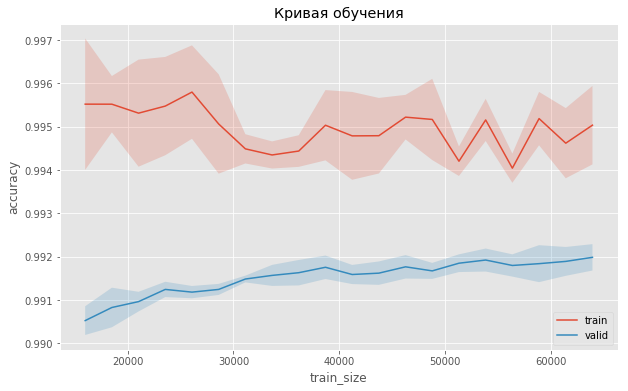

In [24]:
plt.figure(figsize=(10,6))
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')
plt.title('Кривая обучения');

Можно сделать вывод о том, что дальнейшее увеличение выборки не даст значительного увеличения качества.Визуально видно, что график результатов на тестовой выборки вышел на свою асимптоту в районе 92%.

Давайте попробуем посмотреть качество мультиклассовой классификации сессий на пользователей на разных параметрах длины сессии и ширины окна.

In [21]:
estimator = SGDClassifier(random_state=17, loss='log', max_iter=20, n_jobs=-1)
for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_nf = os.path.join(PATH_TO_DATA, 'new_features_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_sf = os.path.join(PATH_TO_DATA, 'selected_features_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print('cv score: {}, test_score: {}'.format(*model_assessment(estimator, 
             path_to_X_pkl, path_to_nf, path_to_sf, path_to_y_pkl, skf, random_state=17, test_size=0.3)),
          'window: {}, session {}'.format(window_size, session_length))

cv score: 0.334, test_score: 0.318 window: 5, session 5
cv score: 0.398, test_score: 0.396 window: 7, session 7
cv score: 0.442, test_score: 0.448 window: 10, session 10


Результаты не впечатляют. Думаю рано думать о практическом приминении этой модели для решения задачи многоклассовой классификации.

## VI. Выводы.

Модель дает приемлемое качество в задачах где нужно отличить какого-то конкретного пользователя от всех остальных.

Подходит для решения такой задачи как защита персональных данных( например почтового ящика или личного кабинета в банке).

Также можно было бы попытататься сгруппировать пользователей по их поведению в сети и разбить на кластеры, изучить эти кластеры и использовать для направленной рекламы.